# Weight Initialization

__Créditos__

Este material es parte integral del programa académico de Udacity "Deep Learning Nanodegree Foundation" (https://github.com/udacity/deep-learning) y fue adaptado al español con propósito de ser un ejemplo práctico del desempeño de Batch normalization.


En esta lección, aprenderás a seleccionar los valores iniciales de pesos adecuados para tu red neuronal. Esto es muy importante para tener una solución óptima lo más rápido posible. 

## Pesos de prueba

### Base de datos

Para demostrar el impacto de los pesos en el desempeño de nuestra red, los probaremos en para la misma base de datos y red neuronal. 

Para este ejercicio, utilizaremos [MNIST](https://en.wikipedia.org/wiki/MNIST_database) para demostrar la diferencia en los pesos iniciales. Como recordatorio, la base de datos MNIST contiene imágenes a mano alzada de dígitos numéricos, 0-9, con entradas normalizadas (0.0 - 1.0).

In [3]:
# Importa librerías
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

%matplotlib inline

import tensorflow as tf
import helper

from tensorflow.examples.tutorials.mnist import input_data

# Importa la base de datos
print('Getting MNIST Dataset...')
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
print('Data Extracted.')

Getting MNIST Dataset...
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Data Extracted.


### Redes neuronales
<img style="float: left" src="images/neural_network.png"/>

Para la primera red neuronal, utilizaremos 3 capas con función de activación ReLU y optimizador Adam.

In [4]:
# Guarda la forma de los pesos para cada capa
layer_1_weight_shape = (mnist.train.images.shape[1], 256)
layer_2_weight_shape = (256, 128)
layer_3_weight_shape = (128, mnist.train.labels.shape[1])

## Inicializa los pesos

### Ceros o unos
Si seguimos el principio de [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor), probablemente pienses que inicializar todos los pesos en 0 o 1 es la mejor solución. Bueno, no es el caso.

Con pesos iguales, todas las neuronas en cada capa producen la misma salida. Esto dificulta decidir que pesos debemos ajustar.

Comparemos la pérdida con todos los pesos ceros y unos utilizando `helper.compare_init_weights`. Esta función utilizará dos pesos iniciales diferentes en la red neuronal con más de 2 epochs. Graficará la pérdida para los primeros 100 batches e imprimirá los estados depués de 2 epochs (~860 batches). Graficamos los primeros 100 batches para analizar los pesos que se comportaron mejor en el inicio.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



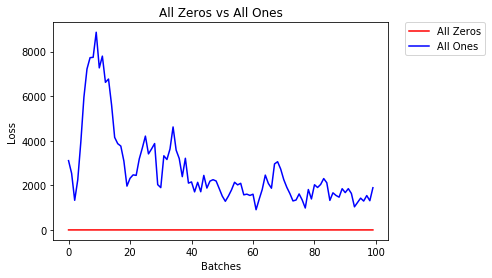

After 858 Batches (2 Epochs):
Validation Accuracy
   11.260% -- All Zeros
    9.900% -- All Ones
Loss
    2.301  -- All Zeros
  182.764  -- All Ones


In [5]:
all_zero_weights = [
    tf.Variable(tf.zeros(layer_1_weight_shape)),
    tf.Variable(tf.zeros(layer_2_weight_shape)),
    tf.Variable(tf.zeros(layer_3_weight_shape))
]

all_one_weights = [
    tf.Variable(tf.ones(layer_1_weight_shape)),
    tf.Variable(tf.ones(layer_2_weight_shape)),
    tf.Variable(tf.ones(layer_3_weight_shape))
]

helper.compare_init_weights(
    mnist,
    'All Zeros vs All Ones',
    [
        (all_zero_weights, 'All Zeros'),
        (all_one_weights, 'All Ones')])

Como puedes ver, la exactitud de predicción utilizando unos y ceros es alrededor del 10%.

La red neuronal tiene problemas en determinar que pesos necesita cambiar, debido a que las neuronas tienen la misma salida para cada capa. Para evitar neuronas con la misma salida, utiliza pesos únicos. También podemos seleccionar los pesos aleatoriamente para evitar estancarnos en un mínimo local en cada prueba.

Una buena solución para obtener estos pesos aleatoriamente es muestrearlos con una distribución uniforme.

### Distribución uniforme
Una [distribución uniforme](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous%29) tiene la misma probabilidad de seleccionar cualquier número de un conjunto de números. Estaremos seleccionando desde una distribución continua, por lo que la probabilidad de seleccionar el mismo número es baja. Utilizaremos la función de TensorFlow `tf.random_uniform` para seleccionar los números de esta forma.

>#### [`tf.random_uniform(shape, minval=0, maxval=None, dtype=tf.float32, seed=None, name=None)`](https://www.tensorflow.org/api_docs/python/tf/random_uniform)
>Valores de salida aleatorios de una distribución uniforme.

>Los valores generados siguen una distribución uniforne en el rango [minval, maxval). El límite inferior minval está incluído en el rango, mientras que el límite superior maxval está excluído.

>- **shape:** A 1-D integer Tensor or Python array. The shape of the output tensor.
- **minval:** A 0-D Tensor or Python value of type dtype. The lower bound on the range of random values to generate. Defaults to 0.
- **maxval:** A 0-D Tensor or Python value of type dtype. The upper bound on the range of random values to generate. Defaults to 1 if dtype is floating point.
- **dtype:** The type of the output: float32, float64, int32, or int64.
- **seed:** A Python integer. Used to create a random seed for the distribution. See tf.set_random_seed for behavior.
- **name:** A name for the operation (optional).

Podemos visualizar la distribución uniforme mediante un histograma. Los valores se pueden mapear desde `tf.random_uniform([1000], -3, 3)` a un histograma utilizando la función `helper.hist_dist`. Éstos serán los `1000` valores flotantes aleatorios de `-3` a `3`, excluyendo el valor `3`.

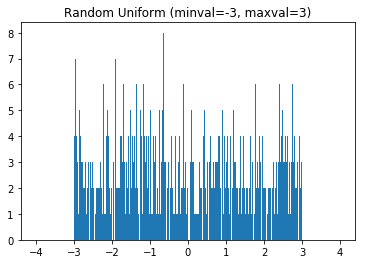

In [4]:
helper.hist_dist('Random Uniform (minval=-3, maxval=3)', tf.random_uniform([1000], -3, 3))

El histograma utiliza 500 buckets para los primeros 1000 valores. Debido a que la probabilidad de cada bucket es la misma, deberán haber alrededor de 2 valores para cada bucket. Esto es exactamente lo que vemos con el histograma. Algunos buckets tienen más y otros menos pero rondan la cantidad de 2.

Ahora que comprendes la función `tf.random_uniform`, vamos a aplicarla para inicializar pesos.

### Baseline


Para conocer el desempeño de entrenamiento de nuestra red utilizando valores predefinidos por `tf.random_uniform`, donde `minval=0.0` y `maxval=1.0`.

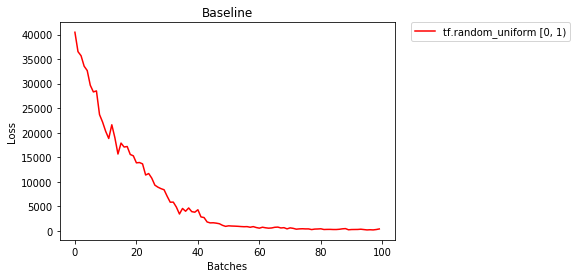

After 858 Batches (2 Epochs):
Validation Accuracy
   78.160% -- tf.random_uniform [0, 1)
Loss
   12.054  -- tf.random_uniform [0, 1)


In [5]:
# El valor predefinido para tf.random_uniform en minval=0 y maxval=1
basline_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape))
]

helper.compare_init_weights(
    mnist,
    'Baseline',
    [(basline_weights, 'tf.random_uniform [0, 1)')])

La gráfica de pérdida muestra que la red neuronal está aprendiendo, lo cual no hacía con los pesos iguales a ceros y unos. Vamos en la dirección correcta.

### Regla general para establecer los pesos
La regla general para establecer los pesos en la red neuronal es establecer valores pequeños pero no demasiados pequeños. Una buena práctica es establecer pesos en el rango de $[-y, y]$ donde $y=1/\sqrt{n}$ ($n$ es el número de entradas de una neurona dada).

Veamos si esto es cierto, primero movamos nuestro centro a cero. Esto nos dará el intervalo [-1, 1).

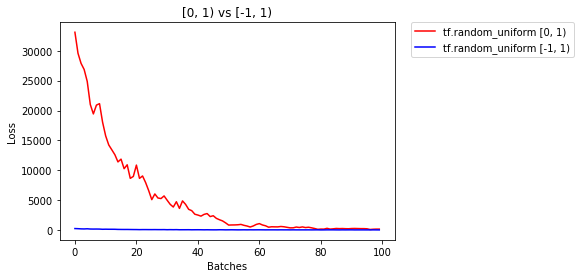

After 858 Batches (2 Epochs):
Validation Accuracy
   71.060% -- tf.random_uniform [0, 1)
   89.620% -- tf.random_uniform [-1, 1)
Loss
   27.544  -- tf.random_uniform [0, 1)
    3.769  -- tf.random_uniform [-1, 1)


In [6]:
uniform_neg1to1_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -1, 1)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -1, 1)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -1, 1))
]

helper.compare_init_weights(
    mnist,
    '[0, 1) vs [-1, 1)',
    [
        (basline_weights, 'tf.random_uniform [0, 1)'),
        (uniform_neg1to1_weights, 'tf.random_uniform [-1, 1)')])

Continuamos en la dirección correcta, la exactitud y pérdida son mejores con [-1, 1). Aún así, queremos pesos más pequeños. Pero, ¿Qué tan lejos podemos llegar antes de que sean demasiado pequeños?

### Muy pequeños
Comparemos [-0.1, 0.1), [-0.01, 0.01), y [-0.001, 0.001) para ver que tan pequeño es pequeño. Estableceremos `plot_n_batches=None` para mostrar todos los batches en la gráfica.

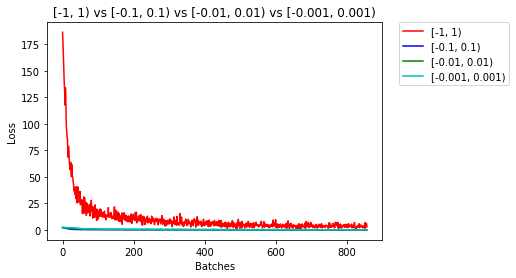

After 858 Batches (2 Epochs):
Validation Accuracy
   90.260% -- [-1, 1)
   97.300% -- [-0.1, 0.1)
   95.580% -- [-0.01, 0.01)
   93.420% -- [-0.001, 0.001)
Loss
    2.739  -- [-1, 1)
    0.100  -- [-0.1, 0.1)
    0.144  -- [-0.01, 0.01)
    0.259  -- [-0.001, 0.001)


In [7]:
uniform_neg01to01_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.1, 0.1)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.1, 0.1)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.1, 0.1))
]

uniform_neg001to001_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.01, 0.01)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.01, 0.01)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.01, 0.01))
]

uniform_neg0001to0001_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.001, 0.001)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.001, 0.001)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.001, 0.001))
]

helper.compare_init_weights(
    mnist,
    '[-1, 1) vs [-0.1, 0.1) vs [-0.01, 0.01) vs [-0.001, 0.001)',
    [
        (uniform_neg1to1_weights, '[-1, 1)'),
        (uniform_neg01to01_weights, '[-0.1, 0.1)'),
        (uniform_neg001to001_weights, '[-0.01, 0.01)'),
        (uniform_neg0001to0001_weights, '[-0.001, 0.001)')],
    plot_n_batches=None)

Parecería que tanto [-0.01, 0.01) o intérvalos más pequeños son demasiado pequeños. Comparemos esto a nuestra regla típica de utilizar el rango $y=1/\sqrt{n}$.

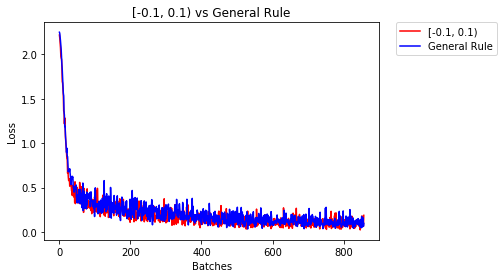

After 858 Batches (2 Epochs):
Validation Accuracy
   96.640% -- [-0.1, 0.1)
   96.900% -- General Rule
Loss
    0.189  -- [-0.1, 0.1)
    0.098  -- General Rule


In [8]:
import numpy as np

general_rule_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -1/np.sqrt(layer_1_weight_shape[0]), 1/np.sqrt(layer_1_weight_shape[0]))),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -1/np.sqrt(layer_2_weight_shape[0]), 1/np.sqrt(layer_2_weight_shape[0]))),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -1/np.sqrt(layer_3_weight_shape[0]), 1/np.sqrt(layer_3_weight_shape[0])))
]

helper.compare_init_weights(
    mnist,
    '[-0.1, 0.1) vs General Rule',
    [
        (uniform_neg01to01_weights, '[-0.1, 0.1)'),
        (general_rule_weights, 'General Rule')],
    plot_n_batches=None)

El rango que encontramos y $y=1/\sqrt{n}$ son muy cercanos.

Debido a que la distribución uniforme tiene la misma probabilidad de seleccionar lo que sea en el intervalo, ¿Qué pasaría si seleccionamos una distribución que tenga una mayor probabilidad de elegir valores cercanos a 0? 

### Distribución normal
A diferencia de la fistribución uniforme, la [distribución normal](https://en.wikipedia.org/wiki/Normal_distribution) tiene un mayor probabilidad de seleccionar un número cercano a la media. Para visualizarlo, grafiquemos valores de la función de TensorFlow `tf.random_normal` a un histograma.

>[tf.random_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)](https://www.tensorflow.org/api_docs/python/tf/random_normal)

>Valores aleatorios de salida para una distribución normal.

>- **shape:** A 1-D integer Tensor or Python array. The shape of the output tensor.
- **mean:** A 0-D Tensor or Python value of type dtype. The mean of the normal distribution.
- **stddev:** A 0-D Tensor or Python value of type dtype. The standard deviation of the normal distribution.
- **dtype:** The type of the output.
- **seed:** A Python integer. Used to create a random seed for the distribution. See tf.set_random_seed for behavior.
- **name:** A name for the operation (optional).

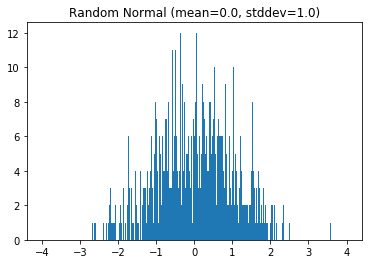

In [9]:
helper.hist_dist('Random Normal (mean=0.0, stddev=1.0)', tf.random_normal([1000]))

Comparemos ambas distribuciones.

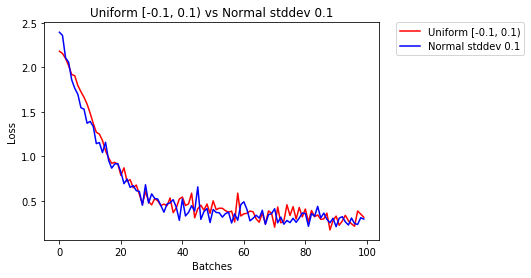

After 858 Batches (2 Epochs):
Validation Accuracy
   97.320% -- Uniform [-0.1, 0.1)
   97.180% -- Normal stddev 0.1
Loss
    0.050  -- Uniform [-0.1, 0.1)
    0.075  -- Normal stddev 0.1


In [10]:
normal_01_weights = [
    tf.Variable(tf.random_normal(layer_1_weight_shape, stddev=0.1)),
    tf.Variable(tf.random_normal(layer_2_weight_shape, stddev=0.1)),
    tf.Variable(tf.random_normal(layer_3_weight_shape, stddev=0.1))
]

helper.compare_init_weights(
    mnist,
    'Uniform [-0.1, 0.1) vs Normal stddev 0.1',
    [
        (uniform_neg01to01_weights, 'Uniform [-0.1, 0.1)'),
        (normal_01_weights, 'Normal stddev 0.1')])

La distribución normal mejora ligeramente la exactitud y pérdida. Acerquémonos más a 0 y dejemos números fuera de la desviación estándar de `x`.  Esta distribución se denomina [Distribución normal truncada](https://en.wikipedia.org/wiki/Truncated_normal_distribution%29).

### Distribución normal truncada
>[tf.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)](https://www.tensorflow.org/api_docs/python/tf/truncated_normal)

>Valores aleatorios para una distribución normal truncada.

>Los valores generados siguen una distribución con media y desviación estándar específicos, excepto los valores cuya magnitud es mayor a 2 veces la desviación estándar de la media son dejados y re-seleccionados.

>- **shape:** A 1-D integer Tensor or Python array. The shape of the output tensor.
- **mean:** A 0-D Tensor or Python value of type dtype. The mean of the truncated normal distribution.
- **stddev:** A 0-D Tensor or Python value of type dtype. The standard deviation of the truncated normal distribution.
- **dtype:** The type of the output.
- **seed:** A Python integer. Used to create a random seed for the distribution. See tf.set_random_seed for behavior.
- **name:** A name for the operation (optional).

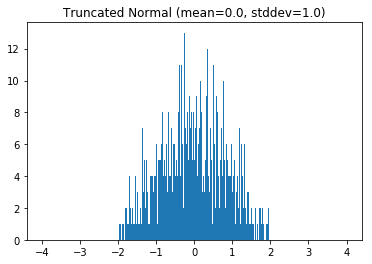

In [11]:
helper.hist_dist('Truncated Normal (mean=0.0, stddev=1.0)', tf.truncated_normal([1000]))

Comparemos los resultados de las distribuciones.

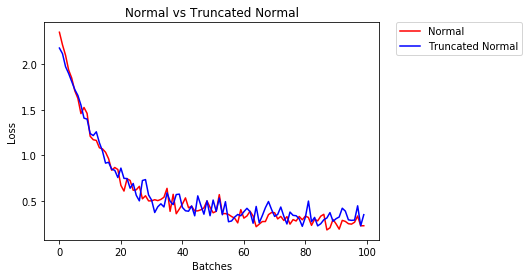

After 858 Batches (2 Epochs):
Validation Accuracy
   97.260% -- Normal
   97.080% -- Truncated Normal
Loss
    0.049  -- Normal
    0.148  -- Truncated Normal


In [12]:
trunc_normal_01_weights = [
    tf.Variable(tf.truncated_normal(layer_1_weight_shape, stddev=0.1)),
    tf.Variable(tf.truncated_normal(layer_2_weight_shape, stddev=0.1)),
    tf.Variable(tf.truncated_normal(layer_3_weight_shape, stddev=0.1))
]

helper.compare_init_weights(
    mnist,
    'Normal vs Truncated Normal',
    [
        (normal_01_weights, 'Normal'),
        (trunc_normal_01_weights, 'Truncated Normal')])

No se aprecia mucha diferencia entre ambas distribuciones. Esto se debe a que la red neuronal que estamos utilizando es muy pequeña. Una red neuronal más grande seleccionará más puntos en la distribución normal, incrementando la probabilidad que sus selecciones sean mayores a 2 desviaciones estándar.

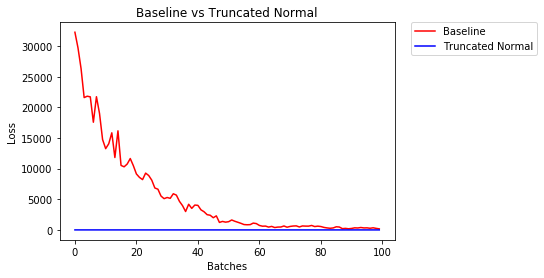

After 858 Batches (2 Epochs):
Validation Accuracy
   81.080% -- Baseline
   97.160% -- Truncated Normal
Loss
   10.496  -- Baseline
    0.100  -- Truncated Normal


In [13]:
helper.compare_init_weights(
    mnist,
    'Baseline vs Truncated Normal',
    [
        (basline_weights, 'Baseline'),
        (trunc_normal_01_weights, 'Truncated Normal')])

La diferencia entre el baseline y la distribución normal truncada es enorme. Sin embargo, existen más herramientas para mejorar todavía la inicialización de pesos.